Takes a lat/lon or address,

Queries nearby places via Google API, needs activation of billing or free trial to generate API key. A single location name can have multiple addresses/ place_ids. This is a bit tricky.

You can check place_id also here https://developers.google.com/maps/documentation/places/web-service/place-id

Filters likely candidates (restaurants, cafes, etc.),

And checks which have Popular Times via Selenium.

In [ ]:
API_KEY = "Replace with your Google API Key"

In [31]:
import googlemaps

def get_place_id(address, api_key):
    # Initialize client
    gmaps = googlemaps.Client(key=api_key)

    # Use the geocode API to get place info
    geocode_result = gmaps.geocode(address)

    if not geocode_result:
        print(f"No results found for: {address}")
        return None

    # Extract place_id
    place_id = geocode_result[0].get("place_id")
    print(f"Address: {address}")
    print(f"Place ID: {place_id}")
    return place_id


# Example usage
if __name__ == "__main__":

    # address = "NOCHIKUPPAM BEACH Santhome, Chennai, Tamil Nadu 600004, India"
    # place_id = get_place_id(address, API_KEY)


    address = "Prereeta Beach, Puri, Odisha, India"
    place_id = get_place_id(address, API_KEY)


Address: Prereeta Beach, Puri, Odisha, India
Place ID: ChIJidc0oh3FGToRXA5avcinzIk


Start selenium

In [32]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
import time
import tempfile
import re
import pandas as pd

options = Options()
options.binary_location = "/home/naveen/tools/firefox64/firefox"
options.profile = tempfile.mkdtemp()
service = Service(executable_path="/home/naveen/miniconda3/envs/webscrap/bin/geckodriver")

Test website

In [33]:
browser = webdriver.Firefox(service=service, options=options)
browser.get("https://www.google.com")
print(browser.title)
browser.quit()

Google


In [34]:
url_string=f'https://www.google.com/maps/place/?q=place_id:{place_id}'
browser = webdriver.Firefox(service=service, options=options)
browser.get(url_string)

# Wait for consent dialog and click "Accept all" (text may vary by language)
try:
    time.sleep(5)
    accept_button = browser.find_element(By.XPATH, "//button[contains(., 'Avvis alle')]")
    accept_button.click()
    time.sleep(1)
except Exception as e:
    print("Consent button not found or already accepted:", e)

print(browser.title)
browser.execute_script("window.scrollTo(0, 20)")

Prereeta Beach - Google Maps


In [35]:
# Get redirected URL after consent
full_url = browser.current_url
print("Redirected URL:", full_url)

# Extract coordinates
match = re.search(r'@(-?\d+\.\d+),(-?\d+\.\d+)', full_url)
if match:
    lat, lon = map(float, match.groups())
    print("Latitude:", lat, "Longitude:", lon)
else:
    print("Coordinates not found in URL")


Redirected URL: https://www.google.com/maps/place/Prereeta+Beach/@19.799435,85.8418667,17z/data=!3m1!4b1!4m6!3m5!1s0x3a19c51da234d789:0x89cca7c8bd5a0e5c!8m2!3d19.799435!4d85.8418667!16s%2Fg%2F11q3x0h_j8?entry=ttu&g_ep=EgoyMDI1MTAyOC4wIKXMDSoASAFQAw%3D%3D
Latitude: 19.799435 Longitude: 85.8418667


Address

In [36]:
#get the addresss
data_item_id=browser.find_elements(By.XPATH,"//button[@data-item-id='address']")

for div in data_item_id:
    if div.get_attribute('aria-label'):
            print(div.get_attribute('aria-label'))
            string=div.get_attribute('aria-label')
            print(string[string.find(": ")+2:])


Adresse: QRXR+QP, Puri, Odisha 752002, India 
QRXR+QP, Puri, Odisha 752002, India 


Popular Time Info

In [37]:
from datetime import datetime, timedelta
def next_hour_str(hour_str):
    """Given 'HH:MM', return next hour as string (with wrap-around)."""
    t = datetime.strptime(hour_str, "%H:%M") + timedelta(hours=1)
    return t.strftime("%H:%M")

In [38]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Find all hourly divs
hourly_divs = browser.find_elements(By.CSS_SELECTOR, 'div.dpoVLd')

data = []
last_hour = None
day_idx = 0
current_day = days[day_idx]
first_entry = True  # flag for first hour

def next_hour_str(hour_str):
    t = datetime.strptime(hour_str, "%H:%M") + timedelta(hours=1)
    return t.strftime("%H:%M")

def hour_decreased(last_hour, new_hour):
    """Return True if new_hour is earlier than last_hour (midnight rollover)."""
    lh = datetime.strptime(last_hour, "%H:%M")
    nh = datetime.strptime(new_hour, "%H:%M")
    return nh < lh

for div in hourly_divs:
    aria_label = div.get_attribute("aria-label").strip()

    # Case 1: Regular hourly data
    match_hourly = re.findall(r'(\d+)\s*%\s*hektisk kl\. (\d{2}:\d{2})', aria_label)
    if match_hourly:
        for percent, hour in match_hourly:

            # Handle day rollover (including first entry starting later than 00:00)
            if last_hour and hour_decreased(last_hour, hour):
                day_idx = (day_idx + 1) % len(days)
                current_day = days[day_idx]

            # First entry sets last_hour without incrementing day
            if first_entry:
                first_entry = False

            last_hour = hour
            data.append({
                'day': current_day,
                'hour': hour,
                'busyness_percent': int(percent),
            })
        continue

    # Case 2: Current time entry
    match_now = re.findall(r'For øyeblikket (\d+)\s*%\s*hektisk, vanligvis (\d+)\s*%\s*hektisk\.', aria_label)
    if match_now and last_hour:
        for current, usual in match_now:
            next_hour = next_hour_str(last_hour)

            # Detect rollover for inferred hour
            if last_hour == "23:00":
                day_idx = (day_idx + 1) % len(days)
                current_day = days[day_idx]

            data.append({
                'day': current_day,
                'hour': next_hour,
                'busyness_percent': int(usual),
            })
            last_hour = next_hour  # advance for subsequent entries

# Build DataFrame
df = pd.DataFrame(data)

# Sort properly
df['day'] = pd.Categorical(df['day'], categories=days, ordered=True)
df = df.sort_values(['day', 'hour']).reset_index(drop=True)

print(df.head(5))


      day   hour  busyness_percent
0  Sunday  00:00                53
1  Sunday  01:00                53
2  Sunday  02:00                51
3  Sunday  03:00                31
4  Sunday  04:00                36


In [39]:
browser.quit()

Make some plots 


/tmp/ipykernel_1791/890125568.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(


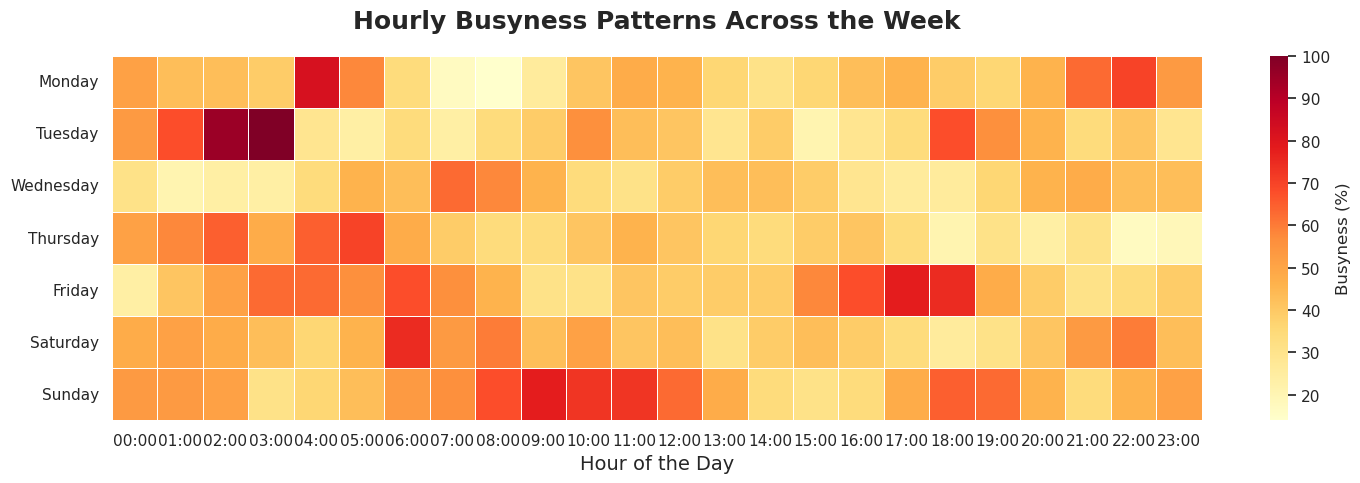

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure df has the right columns
# Columns: ['day', 'hour', 'busyness_percent']

# Handle duplicates: use pivot_table with mean
pivot_df = df.pivot_table(
    index='day',
    columns='hour',
    values='busyness_percent',
    aggfunc='mean'   # or 'median'
)

# Order days for a nice weekly layout
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(ordered_days)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.set_theme(style="white")

ax = sns.heatmap(
    pivot_df,
    cmap="YlOrRd",          # Warm palette
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Busyness (%)'},
    square=False,
)

# Titles & labels for a publication look
plt.title(
    "Hourly Busyness Patterns Across the Week",
    fontsize=18,
    fontweight='bold',
    pad=20
)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("")
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Clean layout
plt.tight_layout()
plt.show()


Alternatively use populartimes package

In [28]:
import populartimes
populartimes.get_id(API_KEY, place_id)

{'id': 'ChIJidc0oh3FGToRXA5avcinzIk',
 'name': 'Prereeta Beach',
 'address': 'QRXR+QP, Puri, Odisha 752002, India',
 'types': ['establishment', 'point_of_interest', 'tourist_attraction'],
 'coordinates': {'lat': 19.799435, 'lng': 85.8418667},
 'rating': 4.4,
 'rating_n': 18,
 'populartimes': [{'name': 'Monday',
   'data': [51,
    43,
    43,
    39,
    82,
    58,
    34,
    17,
    14,
    26,
    41,
    48,
    46,
    36,
    31,
    36,
    43,
    46,
    39,
    36,
    46,
    63,
    70,
    53]},
  {'name': 'Tuesday',
   'data': [53,
    68,
    95,
    100,
    29,
    24,
    34,
    24,
    34,
    39,
    56,
    43,
    41,
    29,
    39,
    21,
    29,
    34,
    68,
    56,
    46,
    34,
    41,
    29]},
  {'name': 'Wednesday',
   'data': [31,
    21,
    24,
    24,
    34,
    46,
    43,
    63,
    58,
    46,
    34,
    31,
    39,
    43,
    43,
    39,
    29,
    26,
    26,
    36,
    46,
    48,
    43,
    43]},
  {'name': 'Thursday',
   'data': 

There is also an option to pull places by catergories and limits using populartimes. See supported types here: https://developers.google.com/maps/documentation/places/web-service/legacy/supported_types 

In [ ]:
bound_lower = (19.792101, 85.816981)
bound_upper = (19.796537, 85.819485)
types = "restaurant"
data = populartimes.get(API_KEY, types=types, p1=bound_lower, p2=bound_upper, all_places=False)

Use API to get list of places and place id - https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=9.351588,76.3643404&radius=1000&key="APIKEY_TO_BE_REPLACED"
Use populartimes package to get popular times data for those place ids